In [1]:
# importing of all needed libraries and modules.  

import wrangle as w
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import spearmanr
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score 
from math import sqrt
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Final Report

## Project Description
Scenario-Zillow would like for me to predict the property tax assessed values of Single-Family Properties in Orange County, Los Angeles County, and Ventura County in California that had a transaction during 2017.
My work will give them more insights and recommendations that may improve their current model.  

## Project Goals & Objectives
### Goals
•	Construct an ML Regression model that predicts property tax assessed values of Single-Family Properties
•	Find the key drivers of property value for single family properties. 
•	Deliver a report.
•	Make recommendations on what works or doesn't work in prediction these home values. 
### Objectives
•	Document code, process, findings, and key takeaways in a jupyter notebook final report.
•	Create modules  that make your process repeatable and your report (notebook) easier to read and follow.
•	Ask questions of the data that will help to understand the drivers of home value. 
•	Construct a model to predict assessed home value for single family properties using regression techniques.
•	Make recommendations to the Zillow data science team about how to improve predictions.
•	Refine work into a report and walk through a 5-minute presentation about your goals, the work you did, why, what you found, your methodologies, and your conclusions.


### Cleaning
In preparing the data I cleaned up any white space, dropped nulls, renamed the columns, dropped fips in place of fips encoded, so the data could be isolated by each county, and removed outliers by dropping propeties that had no bedrooms or no bathrooms, limited the bedroom and bathroom to a max of 5, limited the square footage to no more than 5000, and limited the home value to 1 million dollars.

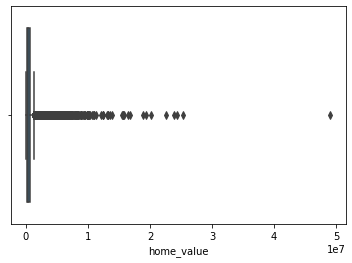

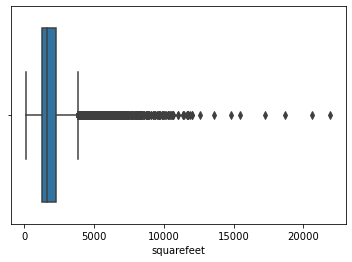

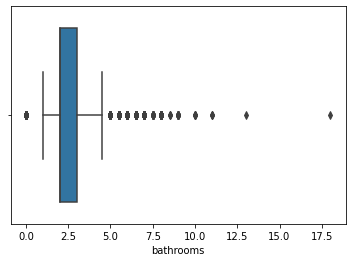

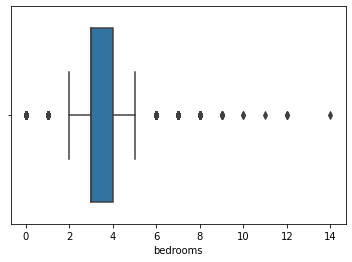

### Exploration Insights
•	H0- The target variable, property tax assessed values ('taxvaluedollarcnt'), of Single Family Properties that had a transaction during 2017 will not be predictable (attributable to any influencing factors) using variables in the dataset.
•	HA- The target variable, property tax assessed values ('taxvaluedollarcnt'), of Single Family Properties that had a transaction during 2017 will be predictable (attributable to any influencing factors) using variables in the dataset.

In [2]:
train, validate, test=w.wrangle_zillow()

In [3]:
scaler, train_scaled, validate_scaled, test_scaled = w.scale_data(train, validate, test, return_scaler=True)

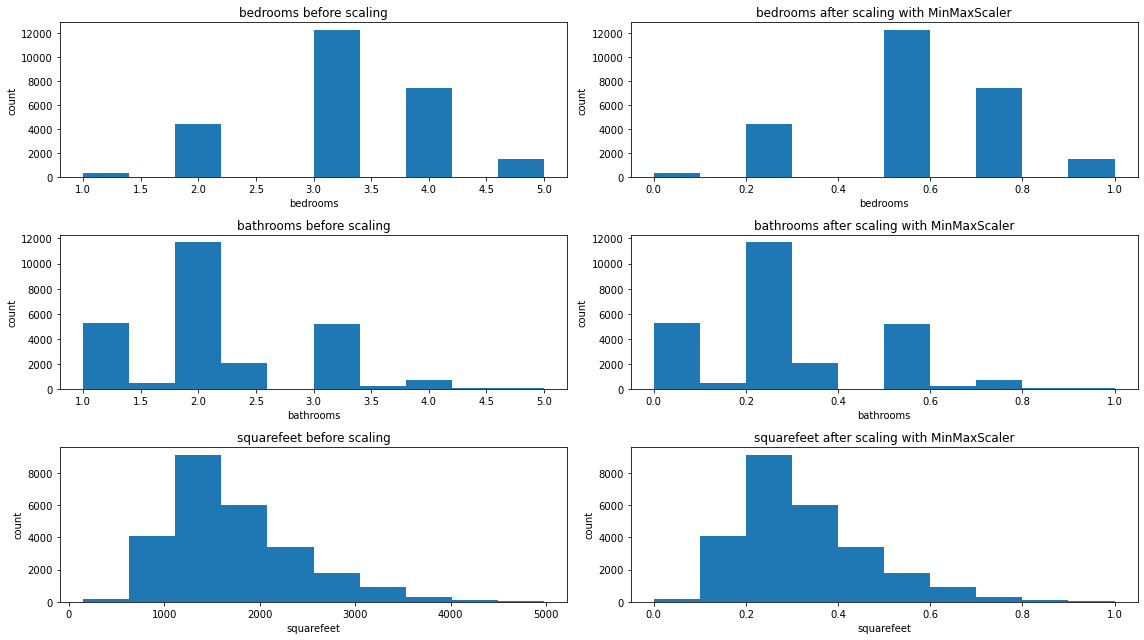

In [4]:
# MinMaxScaler Applied
w.visualize_scaler(scaler=MinMaxScaler(), 
                 df=train, 
                 columns_to_scale=['bedrooms', 'bathrooms', 'squarefeet'], 
                 bins=10)

### Using Spearman's R

The variables 'bedrooms', 'bathrooms', 'squarefeet' have p values of 0 which shows a significant correlation between them and the target variable, home value.

Based on my correlation coefficient and my p-value, I reject my Null hypothesis that there is no correlation between independent variables of bedrooms, bathrooms, and square feet and target variable of home value.

Although all of the independent variables have positive correlations with the target variable, squarefeet is more correlated. This looks to be the best predictor of our target variable. I will perform a simple linear regression first. If I want to go back and do some feature engineering with my other independent variables, I could do that and see if I can improve on my accuracy. And since bathrooms is highly correlated with square feet, I might use that.

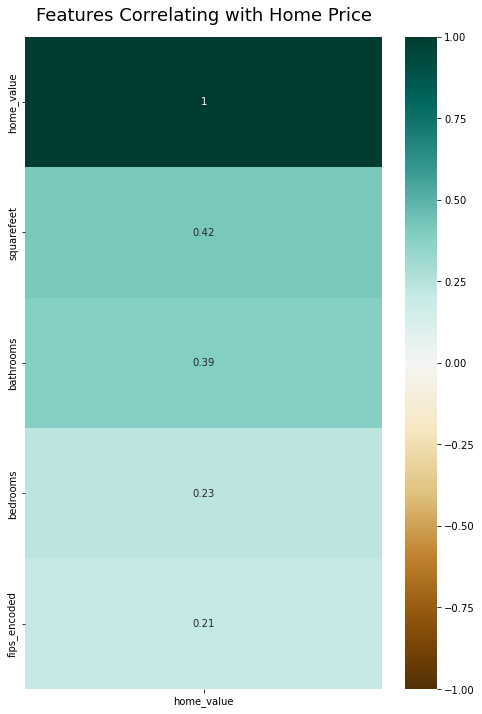

# Ready to Model
I set up the scaled variables to use in my models.

In [5]:
X_train_scaled=train_scaled.drop(columns=['home_value'])
y_train=train_scaled.home_value

In [6]:
X_validate_scaled=validate_scaled.drop(columns=['home_value'])
y_validate=validate_scaled.home_value

In [7]:
X_test_scaled=test_scaled.drop(columns=['home_value'])
y_test=test_scaled.home_value

### Baseline Prediction
Using scaled y_train and y_validate, I got the predictions for both mean.  I used Root Mean Squared Error.

In [8]:
# We need y_train and y_validate (and test) to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

# 1. Predict home_value_pred_mean
home_value_pred_mean = y_train['home_value'].mean()
y_train['home_value_pred_mean'] = home_value_pred_mean
y_validate['home_value_pred_mean'] = home_value_pred_mean

# 2. RMSE of home_value_pred_mean
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))


RMSE using Mean
Train/In-Sample:  235141.65 
Validate/Out-of-Sample:  234344.53


###  Models
The regression models used were OLS, Tweedie, Polynomial 2nd degree, Polynomial 3rd degree, and Lasso Lars.  I created the model object, fit it (and transformed it, if needed), predicted, and evaluated the models.  Best performing was the Polynomial 3rd degree and the worst was Tweedie.

### OLS
Ordinary Least Squares

In [9]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train.home_value)

# predict train
y_train['home_value_pred_lm'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_pred_lm)**(1/2)

# predict validate
y_validate['home_value_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_lm)**(1/2)

print("RMSE for OLS\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS
Training/In-Sample:  206103.53427370606 
Validation/Out-of-Sample:  205052.05700159754


### POLYNOMIAL REGRESSION (2nd degree)

In [10]:
from sklearn.preprocessing import PolynomialFeatures
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

In [11]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.home_value)

# predict train
y_train['home_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_pred_lm2)**(1/2)

# predict validate
y_validate['home_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_lm2)**(1/2)

print("RMSE for Poly 2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Poly 2
Training/In-Sample:  204817.78133544177 
Validation/Out-of-Sample:  203734.47951521567


### POLYNOMIAL REGRESSION (3rd degree)

In [12]:
from sklearn.preprocessing import PolynomialFeatures
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate_scaled)
X_test_degree3 = pf.transform(X_test_scaled)

In [13]:
# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(X_train_degree3, y_train.home_value)

# predict train
y_train['home_value_pred_lm3'] = lm3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_pred_lm3)**(1/2)

# predict validate
y_validate['home_value_pred_lm3'] = lm3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_lm3)**(1/2)

# predict on test
y_test['home_value_pred_lm3'] = lm3.predict(X_test_degree3)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.home_value, y_test.home_value_pred_lm3)**(1/2)

print("RMSE for Poly 3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
      "\nTesting/Out-of-Sample Performance: ", rmse_test)

RMSE for Poly 3
Training/In-Sample:  204428.94260853203 
Validation/Out-of-Sample:  203237.347981703 
Testing/Out-of-Sample Performance:  202729.41849139714


### LASSOLARS

In [14]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train.home_value)

# predict train
y_train['home_value_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_pred_lars)**(1/2)

# predict validate
y_validate['home_value_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  206103.9762725642 
Validation/Out-of-Sample:  205056.07910831872


### TWEEDIE

In [15]:
# create the model object
glm = TweedieRegressor(power=0, alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.home_value)

# predict train
y_train['home_value_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_pred_glm)**(1/2)

# predict validate
y_validate['home_value_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_glm)**(1/2)

print("RMSE for Tweedie\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Tweedie
Training/In-Sample:  230490.8872543744 
Validation/Out-of-Sample:  229745.21998190065


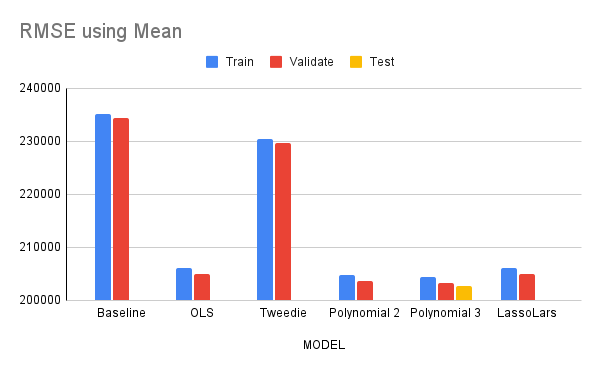

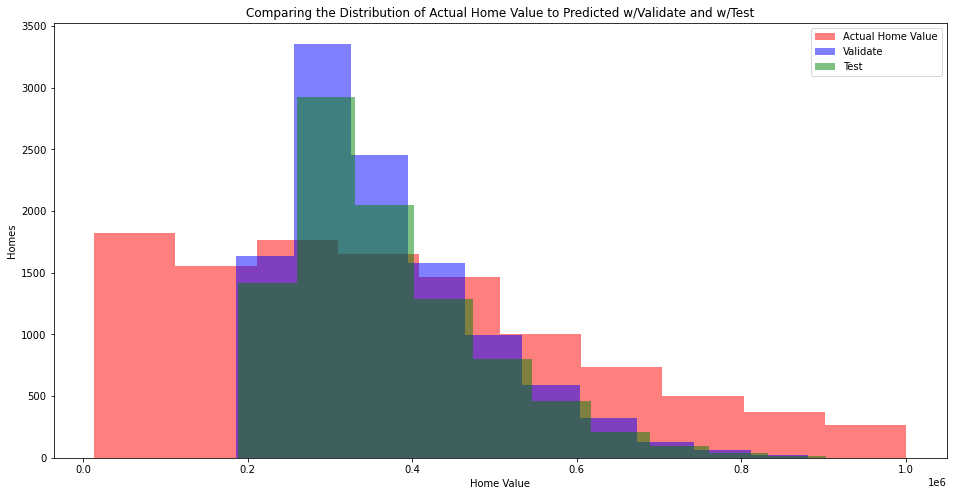

## Conclusion
My orginal goal was to see if using minimal features, could I create a model to predict the home values.  I reached my goal by utilizing the data science pipeline.  I acquired, prepped, explored, used Spearmans r statististical test and evaluated my regression models using the RMSE (mean) on OLS, Tweedie, Polynomial 2nd degree, Polynomial 3rd degree, and LassoLars.  All of the models were better than baseline, but the best model was Polynomial 3rd degree. Based on my correlation coefficient and my p-value, I rejected my Null hypothesis that there is no correlation between independent variables of bedrooms, bathrooms, and square feet and target variable of home value.  I recommend that to better predict home values, that we use more features and if the data was more complete add more specificity by utilizing zipcode or even neighborhood.
Next Step: If I had more time, I would create a different model by including feature engineering.